In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install transformers
!pip install pytypo

     |████████████████████████████████| 1.3MB 8.2MB/s 
     |████████████████████████████████| 2.9MB 56.1MB/s 
     |████████████████████████████████| 1.1MB 60.6MB/s 
     |████████████████████████████████| 890kB 53.9MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=7b8cf7a53e9c6d6f2224972b12c56193c3301d585e46ac1e9b9cc155d757483e
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses
     |████████████████████████████████| 81kB 6.8MB/s 
  Created wheel for pytypo: filename=pytypo-0.3.0-cp36-none-any.whl size=72689 sha256=a6cf4d21f62523fa0d5916ad1c983256a19b164de90d29649cb90c3ff17f5eb6
  Stored in directory: /root/.cache/pip/wheels/f3/81/55/d305159b9e1631c244110dc3b131b1d0dcf041672dd2e8de9a
Successfully built pytypo


In [303]:
pip install emoji

     |████████████████████████████████| 51kB 4.5MB/s 
  Created wheel for emoji: filename=emoji-0.6.0-cp36-none-any.whl size=49716 sha256=65b24703b36fe71ace3bdf61bb1f1d21959f8c98c386ecfdaa2669bed8ec7e12
  Stored in directory: /root/.cache/pip/wheels/46/2c/8b/9dcf5216ca68e14e0320e283692dce8ae321cdc01e73e17796
Successfully built emoji


In [373]:
import pandas as pd
import numpy as np
import pytypo
import re
import tensorflow as tf
import tensorflow_addons as tfa
import emoji

AUTO = tf.data.experimental.AUTOTUNE

data1 = pd.read_excel("/content/drive/My Drive/DimasASu/Data Latih BDC.xlsx")
data2 = pd.read_csv("/content/drive/My Drive/DimasASu/data_clean.csv")

dataTest = pd.read_csv("/content/drive/My Drive/DimasASu/datatest_labelled.csv")

data1.head() , data2.head()

(    ID  ...  nama file gambar
 0   71  ...            71.jpg
 1  461  ...           461.png
 2  495  ...           495.png
 3  550  ...           550.png
 4  681  ...           681.jpg
 
 [5 rows x 6 columns],    Unnamed: 0  ... label
 0           0  ...     1
 1           1  ...     1
 2           2  ...     1
 3           3  ...     1
 4           4  ...     1
 
 [5 rows x 4 columns])

In [4]:
print(f"Columns1 {data1.columns}\nColumns2 {data2.columns}\n\nShape1{data1.shape }\nShape2{data2.shape} ")

Columns1 Index(['ID', 'label', 'tanggal', 'judul', 'narasi', 'nama file gambar'], dtype='object')
Columns2 Index(['Unnamed: 0', 'judul', 'narasi', 'label'], dtype='object')

Shape1(4231, 6)
Shape2(5432, 4) 


In [374]:
data1 = data1[["judul","narasi","label"]]
data2 = data2[["judul","narasi","label"]]

df_train = pd.concat([data1,data2])
df_train = df_train.reset_index().drop("index",axis = 1)
df_train.tail()

,judul,narasi,label
9658,foto raja salman mengangkat tandu jenazah korb...,foto raja salman mengangkat tandu jenazah korb...,1
9659,jokowi dituduh bodoh salah cara dalam bersalam...,jokowi dituduh bodoh salah cara dalam bersalam...,1
9660,jokowi dituduh memasukkan ribuan tenaga kerja ...,jokowi dituduh memasukkan ribuan tenaga kerja ...,1
9661,mata uang rupiah terpuruk,mata uang rupiah terpuruk,1
9662,ahok izinkan natalan di monas tapi larang peng...,ahok izinkan natalan di monas tapi larang peng...,1


In [375]:
print(df_train.isna().sum())
df_train.dropna(inplace = True)
df_train.isna().sum() , df_train.shape

judul     1
narasi    3
label     0
dtype: int64


(judul     0
 narasi    0
 label     0
 dtype: int64, (9660, 3))

In [376]:
sameIndex = []
for key1,val in df_train["judul"].items():
  i = 0
  for key2,val in dataTest["judul"].items():
    if(key1 == key2):
      sameIndex.append(i)
    else:
      i = i + 1
len(sameIndex)

df_train = df_train.drop(sameIndex)
df_train.shape

(9190, 3)

In [377]:
df_train = df_train.sample(frac=1,random_state = 0)
df_train.head()

,judul,narasi,label
2737,Penemuan Sabu di Dalam Nanas Terjadi di Indonesia,Nanas illegal isinya sabu2 yg dikemas. Nanas b...,1
2487,Jokowi Angkat Bicara Terkait Demo Massa #2019G...,"Demo silahkan, tapi mbok yang pinter dikit.",1
9575,warsito dilarang melakukan riset kanker oleh p...,warsito dilarang melakukan riset kanker oleh p...,1
6423,pengurus imi bantah ada korban jiwa di kecelak...,pengurus imi bantah ada korban jiwa di kecelak...,1
7069,terakhir yang diketahui adalah terhadap sam lo...,ternyata penggunaan ular untuk interogasi oran...,1


In [378]:
def clean(text) : 

  text_cleaning_re = "@\S+|https?:\S+|http?:\S|[#]+|[^A-Za-z0-9]+"
  text_cleaning_hash = "#[A-Za-z0-9]+" 
  text_cleaning_num = "(^|\W)\d+"

  text = re.sub(text_cleaning_hash, " ", text).strip()
  text = re.sub(text_cleaning_num, " ", text).strip()
  text = re.sub(text_cleaning_re, " ", text).strip()
  
  text = text.strip()

  out = []
  for word in text.split() :
    # try : 
    #   out.append(word.replace(word, slang[word]))
    # except Exception as e : 
    out.append(word)
      
  return pytypo.correct_sentence(" ".join(out).strip())


In [379]:
def freeEmoji(text):
    allchars = [str for str in text]
    emoji_list = [c for c in allchars if c in emoji.UNICODE_EMOJI]
    clean_text = ' '.join([str for str in text.split() if not any(i in str for i in emoji_list)])
    return clean_text

In [380]:
df_train["narasi"] = df_train["narasi"].apply(clean)
df_train["judul"] = df_train["judul"].apply(clean)

dataTest["narasi"] = dataTest["narasi"].apply(clean)
dataTest["judul"] = dataTest["judul"].apply(clean)

df_train["narasi"] = df_train["narasi"].apply(freeEmoji)
df_train["judul"] = df_train["judul"].apply(freeEmoji)

dataTest["narasi"] = dataTest["narasi"].apply(freeEmoji)
dataTest["judul"] = dataTest["judul"].apply(freeEmoji)



In [381]:
df_train.head(10)

,judul,narasi,label
2737,Penemuan Sabu di Dalam Nanas Terjadi di Indonesia,Nanas illegal isinya sabu2 yg dikemas Nanas bu...,1
2487,Jokowi Angkat Bicara Terkait Demo Massa di dep...,Demo silahkan tapi mbok yang pinter dikit,1
9575,warsito dilarang melakukan riset kanker oleh p...,warsito dilarang melakukan riset kanker oleh p...,1
6423,pengurus imi bantah ada korban jiwa di kecelak...,pengurus imi bantah ada korban jiwa di kecelak...,1
7069,terakhir yang diketahui adalah terhadap sam lo...,ternyata penggunaan ular untuk interogasi oran...,1
7703,penculikan anak di kusan hilir kabupaten tanah...,info ini bukan hoax sdh terjadi di ds batuah d...,1
9087,dana santunan korban crane sudah cair tapi bel...,dana santunan korban crane sudah cair tapi bel...,1
8761,jokowi bukan seorang insinyur,jokowi bukan seorang insinyur,1
8369,tiang girder proyek becakayu ambruk waskita ka...,tiang girder proyek becakayu ambruk waskita ka...,1
4745,raja salman telah meninggal dan terindikasikan...,raja salman telah meninggal dan terindikasikan...,1


In [11]:
from transformers import AutoTokenizer,TFAutoModel,AutoModel
tokenizer = AutoTokenizer.from_pretrained("indobenchmark/indobert-base-p2")
IndoBert = TFAutoModel.from_pretrained("indobenchmark/indobert-base-p2")

Some layers from the model checkpoint at indobenchmark/indobert-base-p2 were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at indobenchmark/indobert-base-p2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [12]:
from collections import Counter
seq_len = [len(i.split()) for i in df_train["narasi"]]

print(Counter(seq_len))

Counter({7: 559, 8: 558, 9: 539, 10: 475, 11: 466, 6: 450, 12: 364, 5: 350, 13: 336, 14: 273, 15: 252, 4: 227, 16: 207, 17: 188, 18: 180, 20: 152, 19: 142, 3: 140, 24: 124, 22: 121, 27: 115, 21: 115, 26: 105, 23: 103, 28: 102, 29: 96, 36: 94, 32: 92, 25: 88, 31: 87, 30: 82, 33: 77, 34: 76, 37: 73, 38: 70, 39: 65, 40: 64, 41: 63, 35: 61, 42: 61, 43: 54, 2: 52, 50: 46, 44: 46, 46: 44, 47: 44, 48: 43, 45: 42, 51: 36, 59: 31, 54: 30, 49: 30, 55: 29, 58: 27, 53: 24, 56: 24, 52: 23, 60: 20, 65: 19, 66: 19, 63: 19, 72: 19, 77: 19, 76: 17, 57: 17, 83: 15, 61: 15, 68: 15, 64: 14, 62: 13, 71: 13, 75: 12, 67: 12, 86: 11, 74: 11, 70: 11, 80: 10, 69: 10, 78: 9, 79: 9, 92: 9, 110: 9, 1: 9, 84: 8, 95: 7, 87: 7, 73: 7, 113: 7, 85: 7, 139: 6, 104: 6, 81: 6, 156: 6, 115: 6, 82: 6, 96: 6, 88: 6, 101: 6, 108: 6, 129: 6, 111: 5, 102: 5, 268: 5, 123: 5, 259: 4, 119: 4, 135: 4, 91: 4, 122: 4, 173: 4, 157: 4, 93: 4, 98: 4, 100: 4, 252: 4, 132: 3, 213: 3, 152: 3, 106: 3, 126: 3, 154: 3, 116: 3, 155: 3, 180: 3,

In [296]:
"""from sklearn.utils import resample
no_claim = df_train[df_train.label == 1]
claim = df_train[df_train.label == 0]
claim.head()
sampled = resample(claim,replace = True,n_samples = len(no_claim),random_state = 0)
df_train = pd.concat([no_claim,sampled])
df_train.shape
sampled"""

'from sklearn.utils import resample\nno_claim = df_train[df_train.label == 1]\nclaim = df_train[df_train.label == 0]\nclaim.head()\nsampled = resample(claim,replace = True,n_samples = len(no_claim),random_state = 0)\ndf_train = pd.concat([no_claim,sampled])\ndf_train.shape\nsampled'

In [382]:
from sklearn.model_selection import train_test_split

df_train, df_val = train_test_split(df_train,test_size = 0.05 ,random_state = 93)
df_train.shape , df_val.shape


((8730, 3), (460, 3))

In [383]:
tokens_train = {
   "judul":tokenizer.batch_encode_plus(
        df_train.judul.tolist(),
        max_length = 30,
        pad_to_max_length = True,
        truncation = True
   ),
      "narasi":tokenizer.batch_encode_plus(
        df_train.narasi.tolist(),
        max_length = 64,
        pad_to_max_length = True,
        truncation = True
   )
}

tokens_val = {
  'judul' : tokenizer.batch_encode_plus(
    df_val["judul"].tolist(),
    max_length = 30,
    pad_to_max_length=True,
    truncation=True
  ),
  'narasi' : tokenizer.batch_encode_plus(
    df_val["narasi"].tolist(),
    max_length = 64,
    pad_to_max_length=True,
    truncation=True
  )
}

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1944: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [384]:
train_sequence = {
    "judul":tf.convert_to_tensor(tokens_train["judul"]["input_ids"]),
    "narasi":tf.convert_to_tensor(tokens_train["narasi"]["input_ids"])
}
train_mask = {
    "judul":tf.convert_to_tensor(tokens_train["judul"]["attention_mask"]),
    "narasi":tf.convert_to_tensor(tokens_train["narasi"]["attention_mask"])
}
y_train = tf.convert_to_tensor(df_train.label.tolist())

validation_sequence = {
    "judul":tf.convert_to_tensor(tokens_val["judul"]["input_ids"]),
    "narasi":tf.convert_to_tensor(tokens_val["narasi"]["input_ids"])
}
validation_mask = {
    "judul":tf.convert_to_tensor(tokens_val["judul"]["attention_mask"]),
    "narasi":tf.convert_to_tensor(tokens_val["narasi"]["attention_mask"])
}
y_val = tf.convert_to_tensor(df_val.label.tolist())

y_train



<tf.Tensor: shape=(8730,), dtype=int32, numpy=array([1, 1, 1, ..., 1, 1, 0], dtype=int32)>

In [385]:
train_data = {
    "judul":tf.squeeze(tf.convert_to_tensor(tokens_train["judul"]["input_ids"])),
    "narasi":tf.squeeze(tf.convert_to_tensor(tokens_train["narasi"]["input_ids"])),
    "judulmask":tf.squeeze(tf.convert_to_tensor(tokens_train["judul"]["attention_mask"])),
    "narasimask":tf.squeeze(tf.convert_to_tensor(tokens_train["narasi"]["attention_mask"]))
}

validation_sequence = {
    "judul":tf.convert_to_tensor(tokens_val["judul"]["input_ids"]),
    "narasi":tf.convert_to_tensor(tokens_val["narasi"]["input_ids"]),
    "judulmask":tf.convert_to_tensor(tokens_val["judul"]["attention_mask"]),
    "narasimask":tf.convert_to_tensor(tokens_val["narasi"]["attention_mask"])
}

y_val = tf.convert_to_tensor(df_val.label.tolist())



In [386]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train,2)
y_val = to_categorical(y_val,2)

In [387]:
dataset = (tf.data.Dataset.from_tensor_slices((train_data,y_train))
    .batch(32)
    .prefetch(AUTO)
           )
dataVal = (tf.data.Dataset.from_tensor_slices((validation_sequence,y_val))
    .batch(32)
    .prefetch(AUTO)
    .cache()
           )

In [331]:
Counter(df_train["label"])
Yatoiba = np.log(5592/5680)
Yatoiba

-0.015614227801550827

In [467]:
def makemodel(output_bias = None):


  ids1 = tf.keras.layers.Input(shape=(30,),dtype=tf.int32,name="judul")
  att1 = tf.keras.layers.Input((30,),dtype = tf.int32,name="judulatt")
  output_bias = tf.keras.initializers.Constant(output_bias)
  ids2 = tf.keras.layers.Input((64,),dtype=tf.int32,name="narasi")
  att2 = tf.keras.layers.Input((64,),dtype=tf.int32,name="narasiatt")
    
  embed1,ya = IndoBert(ids1,attention_mask=att1)
  embed2,toi= IndoBert(ids2,attention_mask=att2)

  embed3,iba = IndoBert(ids1,attention_mask=att1)
  embed4,yatoiba = IndoBert(ids2,attention_mask=att2)

  y = tf.keras.layers.concatenate([iba,yatoiba])
  y = tf.keras.layers.Masking(mask_value = 0)(y)
  y = tf.keras.layers.Dense(units = 32,activation = "relu")(y)

  x = tf.keras.layers.concatenate([ya,toi])
  x = tf.keras.layers.Masking(mask_value = 0)(x)
  x = tf.keras.layers.Dense(16,activation = 'relu')(x)

  fin =  tf.keras.layers.concatenate([x,y])

  fin2 = tf.keras.layers.GlobalAveragePooling1D()(embed1)
  fin3 = tf.keras.layers.GlobalAveragePooling1D()(embed2)
  fin4 = tf.keras.layers.GlobalAveragePooling1D()(embed3)
  fin4 = tf.keras.layers.Dense(units = 64, activation="relu")(fin4)

  fin5 = tf.keras.layers.GlobalAveragePooling1D()(embed4)
  fin5 = tf.keras.layers.Dense(units = 32, activation = "relu")(fin5)

  fin = tf.keras.layers.concatenate([fin,fin2,fin3,fin4,fin5])
  fin = tf.keras.layers.Dropout(0.35)(fin)
  fin = tf.keras.layers.Dense(units = 34,activation = "relu")(fin)
  fin = tf.keras.layers.Dropout(0.3)(fin)
  fin = tf.keras.layers.Dense(2,activation="softmax")(fin)




  final = tf.keras.Model(inputs=[ids1, att1,ids2,att2],outputs=[fin])
  METRICS = [
        tf.keras.metrics.TruePositives(name='tp'),
        tf.keras.metrics.FalsePositives(name='fp'),
        tf.keras.metrics.TrueNegatives(name='tn'),
        tf.keras.metrics.FalseNegatives(name='fn'), 
        tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc'),
  ] 


  for layer in final.layers:
    layer.trainable = False
  for layer in final.layers[-7:]:
      layer.trainable = True

  optimizer = tf.keras.optimizers.Adam(learning_rate=.001,clipnorm=0.001)
  final.compile(loss=tfa.losses.SigmoidFocalCrossEntropy(), optimizer=optimizer,metrics = METRICS)

  return final

final = makemodel(Yatoiba)

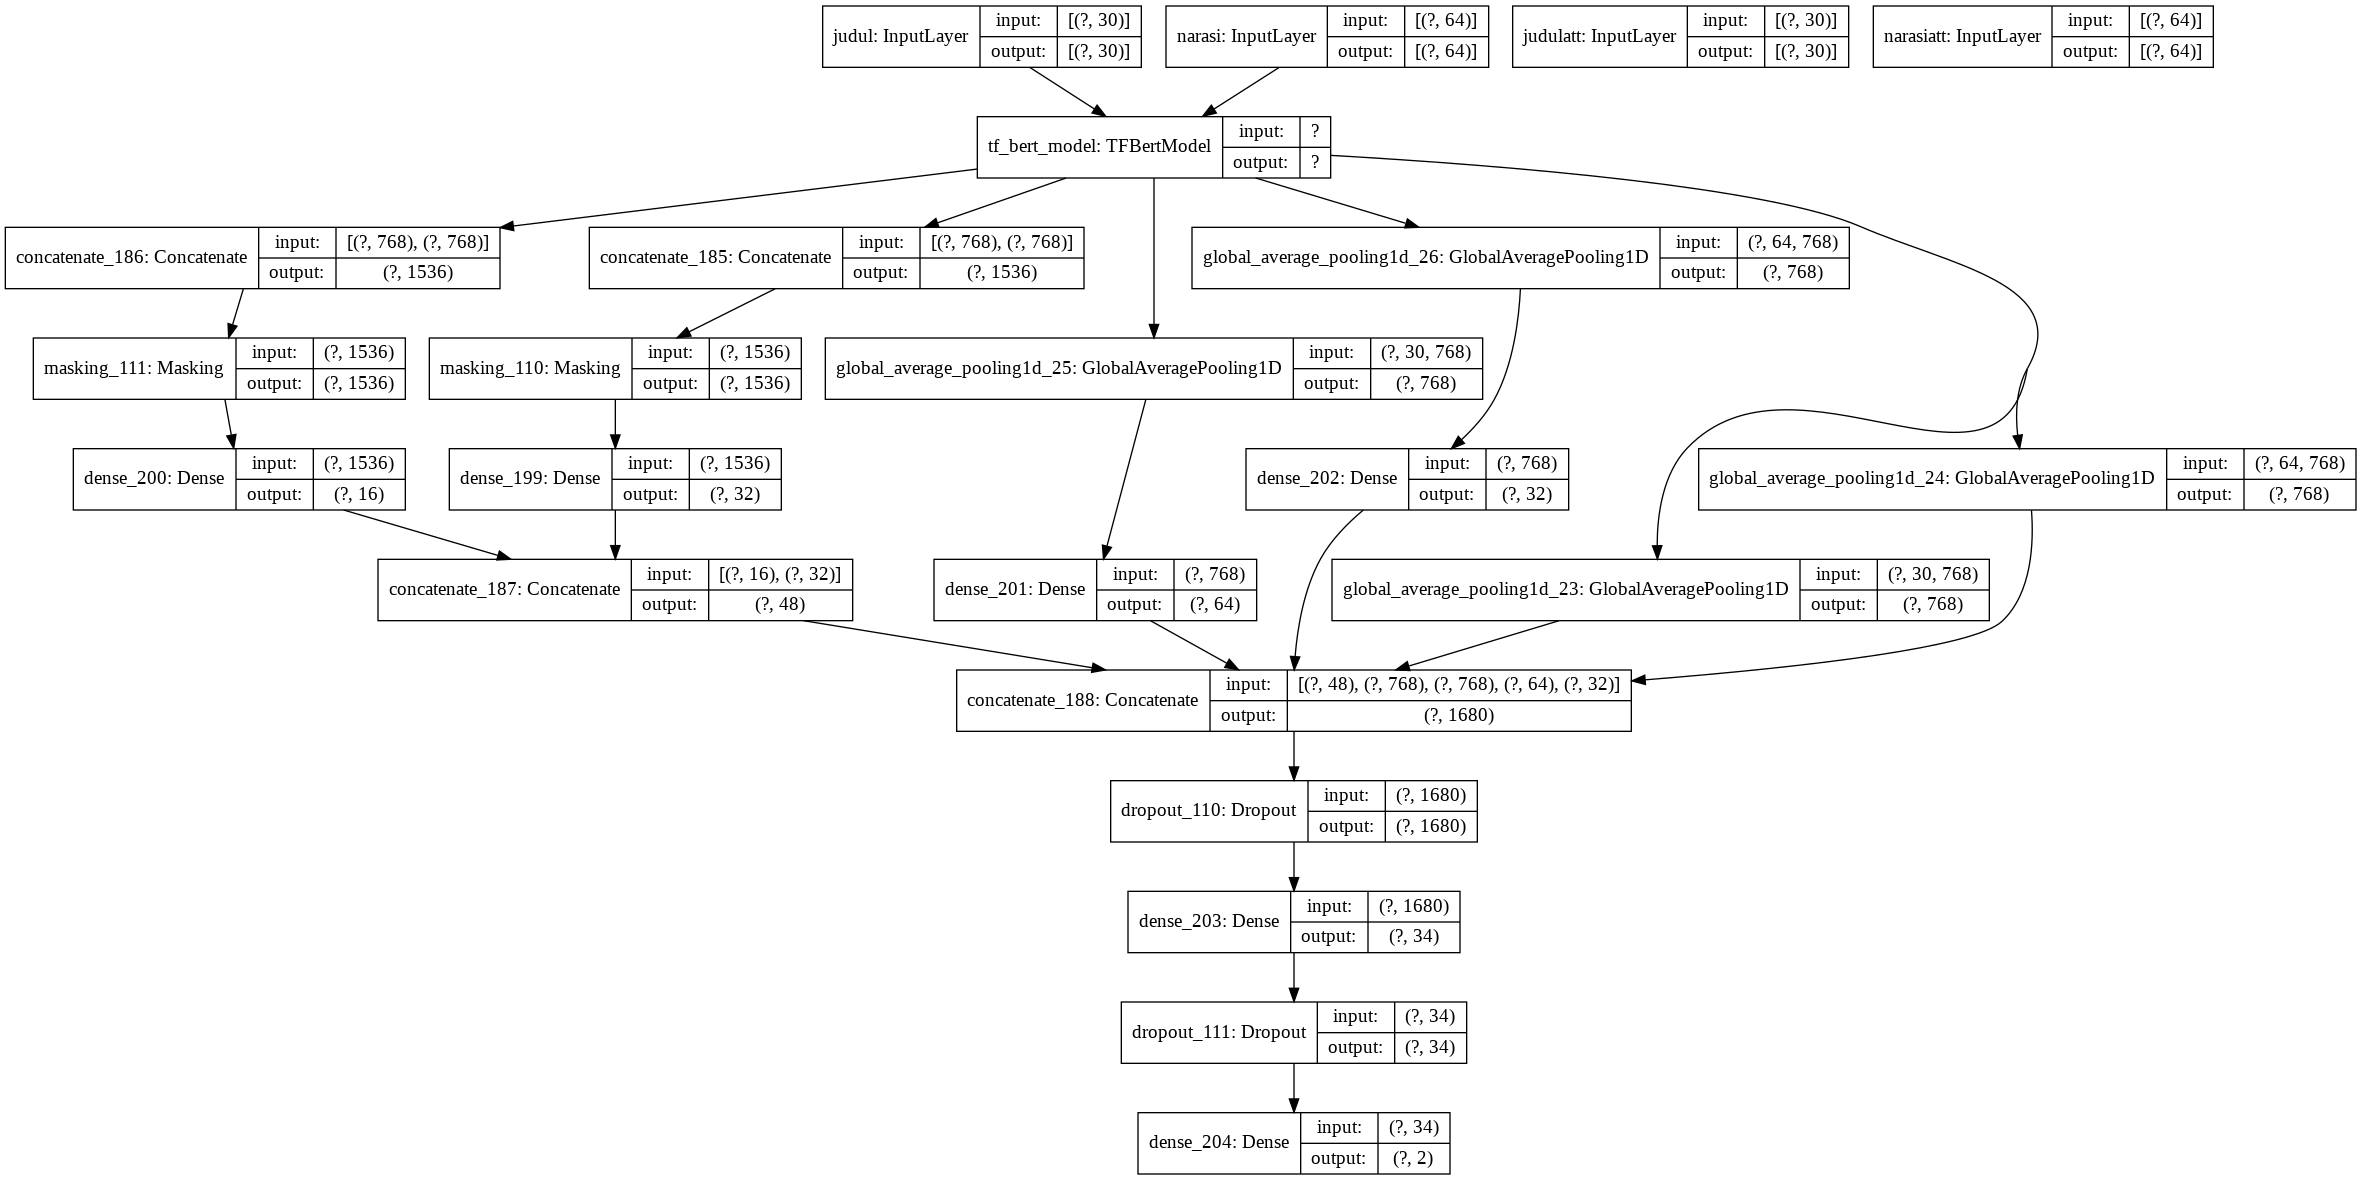

In [468]:
from tensorflow.keras.utils import plot_model
plot_model(final,"modelarhcitect.png",show_shapes=True)

In [469]:
final.summary()

Model: "functional_123"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
judul (InputLayer)              [(None, 30)]         0                                            
__________________________________________________________________________________________________
judulatt (InputLayer)           [(None, 30)]         0                                            
__________________________________________________________________________________________________
narasi (InputLayer)             [(None, 64)]         0                                            
__________________________________________________________________________________________________
narasiatt (InputLayer)          [(None, 64)]         0                                            
_____________________________________________________________________________________

In [455]:
from tensorflow.keras.callbacks import EarlyStopping
EarlyStop = EarlyStopping(monitor="val_loss",patience = 5)

In [464]:
import math
def create_learning_rate_scheduler(max_learn_rate=1e-2,
                                   end_learn_rate=1e-6,
                                   warmup_epoch_count=3,
                                   total_epoch_count=15):

    def lr_scheduler(epoch):
        if epoch < warmup_epoch_count:
            res = max_learn_rate
        else:
            res = max_learn_rate*math.exp(math.log(end_learn_rate/max_learn_rate)*(epoch-warmup_epoch_count+1)/(total_epoch_count-warmup_epoch_count+1))
        return float(res)
    learning_rate_scheduler = tf.keras.callbacks.LearningRateScheduler(lr_scheduler, verbose=1)

    return learning_rate_scheduler

In [470]:
history3=final.fit(x = dataset,epochs = 15,validation_data=dataVal,callbacks = [EarlyStop, create_learning_rate_scheduler(max_learn_rate=1e-3,
                                                    end_learn_rate=1e-6,
                                                    warmup_epoch_count=3,
                                                    total_epoch_count=15),EarlyStop])


Epoch 00001: LearningRateScheduler reducing learning rate to 0.001.
Epoch 1/15
273/273 [==============================] - 126s 461ms/step - loss: 0.1126 - tp: 7377.0000 - fp: 1353.0000 - tn: 7377.0000 - fn: 1353.0000 - accuracy: 0.8450 - precision: 0.8450 - recall: 0.8450 - auc: 0.9028 - val_loss: 0.0849 - val_tp: 400.0000 - val_fp: 60.0000 - val_tn: 400.0000 - val_fn: 60.0000 - val_accuracy: 0.8696 - val_precision: 0.8696 - val_recall: 0.8696 - val_auc: 0.9383

Epoch 00002: LearningRateScheduler reducing learning rate to 0.001.
Epoch 2/15
273/273 [==============================] - 120s 439ms/step - loss: 0.0915 - tp: 7602.0000 - fp: 1128.0000 - tn: 7602.0000 - fn: 1128.0000 - accuracy: 0.8708 - precision: 0.8708 - recall: 0.8708 - auc: 0.9310 - val_loss: 0.0821 - val_tp: 408.0000 - val_fp: 52.0000 - val_tn: 408.0000 - val_fn: 52.0000 - val_accuracy: 0.8870 - val_precision: 0.8870 - val_recall: 0.8870 - val_auc: 0.9402

Epoch 00003: LearningRateScheduler reducing learning rate to 0.00

In [447]:
test_seq = {
  'judul' : tokenizer.batch_encode_plus(
    dataTest["judul"].tolist(),
    max_length = 30,
    pad_to_max_length=True,
    truncation=True
  ),
  'narasi' : tokenizer.batch_encode_plus(
    dataTest["narasi"].tolist(),
    max_length = 64,
    pad_to_max_length=True,
    truncation=True
  )
}

test_sequence = {
    "judul":tf.convert_to_tensor(test_seq["judul"]["input_ids"]),
    "narasi":tf.convert_to_tensor(test_seq["narasi"]["input_ids"]),
    "judulmask":tf.convert_to_tensor(test_seq["judul"]["attention_mask"]),
    "narasimask":tf.convert_to_tensor(test_seq["narasi"]["attention_mask"])
}



/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1944: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [396]:
y_test = dataTest["label"]

In [471]:
y_pred = np.argmax(final.predict(test_sequence),axis = 1)
y_pred[:5]

array([1, 1, 1, 1, 1])

In [472]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.80      0.65      0.72        60
           1       0.95      0.98      0.96       410

    accuracy                           0.93       470
   macro avg       0.87      0.81      0.84       470
weighted avg       0.93      0.93      0.93       470



In [473]:
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

f1_score(y_true = y_test , y_pred = y_pred,average='micro')

0.9340425531914893